## Prepare

In [1]:
!add-apt-repository -y ppa:jonathonf/ffmpeg-4
!apt update
!apt install -y ffmpeg

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/jonathonf/ffmpeg-4/ubuntu bionic InRelease
Readin

In [2]:
!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install librosa
!pip install evaluate>=0.30
!pip install jiwer
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-8vo2jio5
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-8vo2jio5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## Dataset

In [4]:
language = "Swedish"
language_code = "sv-SE"

In [5]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset("mozilla-foundation/common_voice_11_0", language_code, split="train+validation", use_auth_token=True)
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_11_0", language_code, split="test", use_auth_token=True)

print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 12360
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 5069
    })
})


In [6]:
common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])

# Feature Extractor

In [7]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-base")

# Tokenizer

In [8]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-base", language=language, task="transcribe")

## Check first datapoint

In [9]:
input_str = common_voice["train"][0]["sentence"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 Du ser ut att ha gjort det här hela livet.
Decoded w/ special:    <|startoftranscript|><|sv|><|transcribe|><|notimestamps|>Du ser ut att ha gjort det här hela livet.<|endoftext|>
Decoded w/out special: Du ser ut att ha gjort det här hela livet.
Are equal:             True


# Wrapper for both

In [10]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-base", language=language, task="transcribe")

# Explore Data

In [11]:
print(common_voice["train"][0])

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/1aaf2e61fb837413b804938857af61aeb372611d01b80b3f40d9edeb7f354244/common_voice_sv-SE_20466896.mp3', 'array': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'sampling_rate': 48000}, 'sentence': 'Du ser ut att ha gjort det här hela livet.'}


## Change Sampling Rate

In [12]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

print(common_voice["train"][0])

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/1aaf2e61fb837413b804938857af61aeb372611d01b80b3f40d9edeb7f354244/common_voice_sv-SE_20466896.mp3', 'array': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'sampling_rate': 16000}, 'sentence': 'Du ser ut att ha gjort det här hela livet.'}


# Explore

In [13]:
import cv2 as cv

In [14]:
datapoint = common_voice["train"][0]['audio']

In [15]:
extracted = feature_extractor(datapoint['array'], sampling_rate=datapoint["sampling_rate"]).input_features[0]
extracted.shape

(80, 3000)

In [16]:
import matplotlib.pyplot as plt

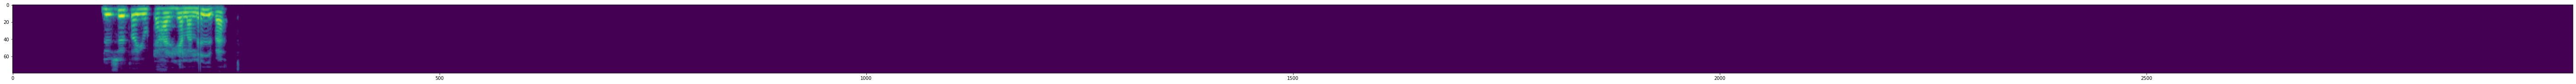

In [17]:
fig = plt.figure(figsize=(100,100))

plt.imshow(extracted)

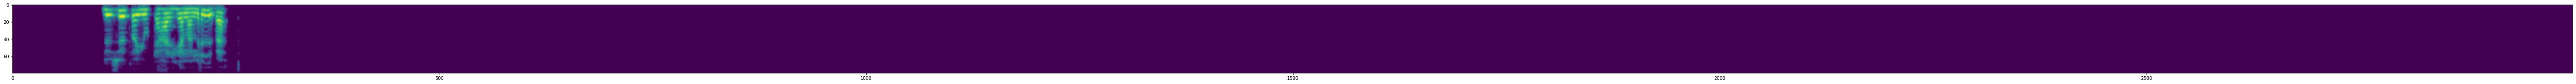

In [18]:
smoothed = cv.blur(extracted, (2,2))

fig = plt.figure(figsize=(100,100))

plt.imshow(smoothed)

# Create Feature Function with blurring

In [19]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array 
    extracted = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    extracted = cv.blur(extracted, (2,2))

    batch["input_features"] = extracted

    # encode target text to label ids 
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

In [22]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=4)

#2:   0%|          | 0/1267 [00:00<?, ?ex/s]

## Save Data

In [23]:
dataset_name = "id2223_whisper_swedish_augmented"

common_voice.push_to_hub(repo_id=dataset_name, private=False)

Pushing dataset shards to the dataset hub:   0%|          | 0/24 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/10 [00:00<?, ?it/s]